In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc

import netCDF4
import numpy as np
import xarray as xr
from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore

from data import GetGFSData
from indices import CalculateIndices

from charts import CalculateCharts
from variables import ExtractVariables

In [2]:
data = xr.open_dataset('data.nc')

processing


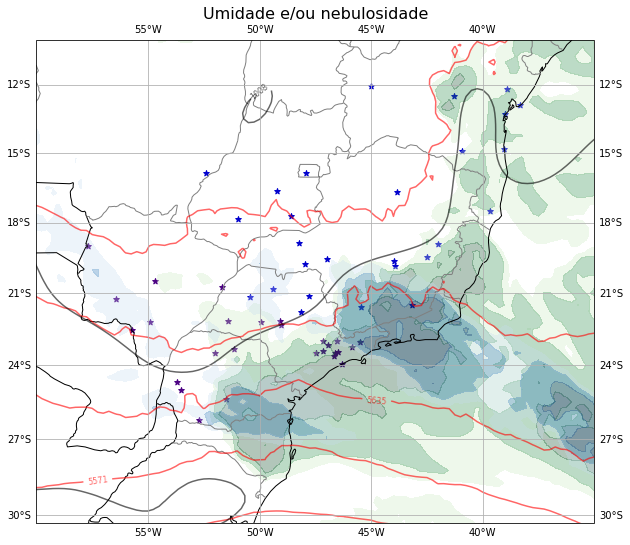

In [3]:
charts = CalculateCharts(data)
showers = charts.clouds_humidity()
plt.savefig('test.png')

In [5]:
variables = ExtractVariables(data)
mslp = variables.mean_sea_level_pressure()
cint = np.linspace(mslp.min(), mslp.max())
cint

array([ 976.60620117,  977.62024175,  978.63428233,  979.6483229 ,
        980.66236348,  981.67640406,  982.69044463,  983.70448521,
        984.71852579,  985.73256637,  986.74660694,  987.76064752,
        988.7746881 ,  989.78872868,  990.80276925,  991.81680983,
        992.83085041,  993.84489098,  994.85893156,  995.87297214,
        996.88701272,  997.90105329,  998.91509387,  999.92913445,
       1000.94317502, 1001.9572156 , 1002.97125618, 1003.98529676,
       1004.99933733, 1006.01337791, 1007.02741849, 1008.04145906,
       1009.05549964, 1010.06954022, 1011.0835808 , 1012.09762137,
       1013.11166195, 1014.12570253, 1015.1397431 , 1016.15378368,
       1017.16782426, 1018.18186484, 1019.19590541, 1020.20994599,
       1021.22398657, 1022.23802714, 1023.25206772, 1024.2661083 ,
       1025.28014888, 1026.29418945])

In [2]:
URL = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
dataset = 'Latest Collection for GFS Quarter Degree Forecast'

variables = ['Relative_humidity_isobaric',
             'Temperature_isobaric',
             'u-component_of_wind_isobaric',
             'v-component_of_wind_isobaric',
             'Best_4_layer_Lifted_Index_surface',
             'Geopotential_height_isobaric',
             'Precipitable_water_entire_atmosphere_single_layer',
             'Pressure_reduced_to_MSL_msl']

gfs = GetGFSData(variables)
data = gfs.get()
data.to_netcdf(path='./data.nc')

Process done in 71.19587111473083 seconds


In [5]:
area_1 = {'SBSR': (-20.816111, -49.404722),
          'SBAU': (-21.144167, -50.426389),
          'SBAQ': (-21.804444, -48.140278),
          'SBRP': (-21.136389, -47.776667),
          'SBAX': (-19.560556, -46.965556),
          'SBUL': (-18.883611, -48.225278),
          'SBUR': (-19.764722, -47.966111),
          'SBVG': (-21.588889, -45.473333),
          'SBZM': (-21.513056, -43.173056),
          'SBBH': (-19.851944, -43.950556),
          'SBCF': (-19.624444, -43.971944),
          'SBMK': (-16.706111, -43.821944),
          'SBIP': (-19.470556, -42.488056),
          'SBGV': (-18.896944, -41.986111),
          'SBBR': (-15.871111, -47.918611),
          'SBGO': (-16.632500, -49.221111),
          'SBCN': (-17.724722, -48.610000),
          'SWLC': (-17.834722, -50.956111),
          'SBBW': (-15.860833, -52.389444),
          'SNBR': (-12.079167, -45.009444),
          'SBLE': (-12.482222, -41.276944),
          'SBVC': (-14.907778, -40.914722),
          'SNVB': (-13.296389, -38.992500),
          'SDIY': (-12.200556, -38.900556),
          'SBSV': (-12.908611, -38.322500),
          'SBIL': (-14.815000, -39.033333),
          'SNTF': (-17.524444, -39.668333)}

[x[-1] for x in area_1.values()]

[-49.404722,
 -50.426389,
 -48.140278,
 -47.776667,
 -46.965556,
 -48.225278,
 -47.966111,
 -45.473333,
 -43.173056,
 -43.950556,
 -43.971944,
 -43.821944,
 -42.488056,
 -41.986111,
 -47.918611,
 -49.221111,
 -48.61,
 -50.956111,
 -52.389444,
 -45.009444,
 -41.276944,
 -40.914722,
 -38.9925,
 -38.900556,
 -38.3225,
 -39.033333,
 -39.668333]

In [6]:
[x[0] for x in area_1.values()]

[-20.816111,
 -21.144167,
 -21.804444,
 -21.136389,
 -19.560556,
 -18.883611,
 -19.764722,
 -21.588889,
 -21.513056,
 -19.851944,
 -19.624444,
 -16.706111,
 -19.470556,
 -18.896944,
 -15.871111,
 -16.6325,
 -17.724722,
 -17.834722,
 -15.860833,
 -12.079167,
 -12.482222,
 -14.907778,
 -13.296389,
 -12.200556,
 -12.908611,
 -14.815,
 -17.524444]